# Basic depth map processing

In [1]:
import cv2
from pathlib import Path
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from IPython.display import clear_output
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
from torchinfo import summary
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import numpy as np

def seed_everything(seed=4242):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

### Visualization

In [2]:
label = 'adl' # fall, adl
sequence_number = random.randint(0, 40 if label == 'adl' else 30) + 1
selected_video = Path(f'../datasets/{label}/sequence-{sequence_number:02}')

frames = sorted(selected_video.glob('*.png'))

for frame_path in frames:

    gray = cv2.imread(str(frame_path), cv2.IMREAD_GRAYSCALE)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)
    viridis = cv2.cvtColor(viridis, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(viridis)

    clear_output(wait=True)
    plt.imshow(img)
    plt.title(f'{label.capitalize()} sequence #{sequence_number}')
    plt.axis('off')
    plt.show()

# Dataset

In [3]:
root = Path('../datasets')
out_root = Path('../data_viridis')

if not out_root.exists():
    out_root.mkdir(exist_ok=True)

    for cls in ['adl', 'fall']:
        for seq in (root / cls).iterdir():
            out_seq = out_root / cls / seq.name
            out_seq.mkdir(parents=True, exist_ok=True)

            for f in seq.glob('*.png'):
                gray = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
                gray = cv2.resize(gray, (128, 128), interpolation=cv2.INTER_LINEAR)
                gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
                viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)
                viridis = cv2.cvtColor(viridis, cv2.COLOR_BGR2RGB)
                arr = np.array(viridis, dtype=np.uint8)
                np.save(out_seq / f'{f.stem}.npy', arr)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, number_of_frames=180):
        self.samples = []
        self.transform = transform
        self.number_of_frames = number_of_frames

        classes = ['adl', 'fall']
        for label_idx, cls in enumerate(classes):
            cls_path = Path(root_dir) / cls
            for seq_folder in cls_path.iterdir():
                frames = sorted(seq_folder.glob('*.npy'))
                if frames:
                    self.samples.append((frames, label_idx))

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]

        if len(frame_paths) >= self.number_of_frames:
            frame_paths = frame_paths[-self.number_of_frames:]
        else:
            frame_paths = [frame_paths[0]] * (self.number_of_frames - len(frame_paths)) + frame_paths

        imgs = []
        for f in frame_paths:
            arr = np.load(f).astype(np.float32)          # (H, W, 3)
            img = Image.fromarray((arr * 255).astype(np.uint8)) # (3, H, W)

            if self.transform:
                img = self.transform(img)

            imgs.append(img)

        video = torch.stack(imgs)  # (T, 3, H, W)
        return video, label


    def __len__(self):
        return len(self.samples)




In [5]:
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
root_dir = Path(out_root)

dataset = VideoDataset(root_dir, transform)

### Model

In [6]:
class CNN_LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_classes=2):
        super(CNN_LSTM, self).__init__()
        
        self.cnn = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # output: (B, 512, 1, 1)

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.feature_dim = 512
        self.lstm = nn.LSTM(input_size=self.feature_dim, hidden_size=hidden_size, 
                          num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        '''
        x: (B, T, C, H, W)
        B = batch_size
        T = num_frames
        C = channels
        H = height
        W = width
        '''
        B, T, C, H, W = x.size()

        cnn_features = []
        for t in range(T):
            frame = x[:, t, :, :, :]        # (B, C, H, W)
            feat = self.cnn(frame)          # (B, 512, 1, 1)
            feat = feat.view(B, -1)         # (B, 512)
            cnn_features.append(feat)
        

        cnn_features = torch.stack(cnn_features, dim=1)

        lstm_out, _ = self.lstm(cnn_features) 

        last_time_step = lstm_out[:, -1, :] # (B, hidden_size)
        out = self.fc(last_time_step) # (B, num_classes)
        return out

In [7]:
model = CNN_LSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

summary(model, input_size=(4, 256, 3, 128, 128), device=device)

Layer (type:depth-idx)                        Output Shape              Param #
CNN_LSTM                                      [4, 2]                    --
├─Sequential: 1-1                             [4, 512, 1, 1]            --
│    └─Conv2d: 2-1                            [4, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [4, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [4, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [4, 64, 32, 32]           --
│    └─Sequential: 2-5                        [4, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [4, 64, 32, 32]           (73,984)
│    │    └─BasicBlock: 3-2                   [4, 64, 32, 32]           (73,984)
│    └─Sequential: 2-6                        [4, 128, 16, 16]          --
│    │    └─BasicBlock: 3-3                   [4, 128, 16, 16]          (230,144)
│    │    └─BasicBlock: 3-4                   [4, 128, 16, 16]      

### Training

In [8]:
num_epochs = 10
batch_size = 4
num_folds = 10

g = torch.Generator()
g.manual_seed(42)
seed_everything(42)

indices = np.arange(len(dataset))
labels = np.array([dataset[i][1] for i in indices])

skf = StratifiedKFold(
    n_splits=num_folds,
    shuffle=True,
    random_state=42
)

checkpoint_dir = Path('../models/viridis_colormap')
checkpoint_dir.mkdir(exist_ok=True, parents=True)



========== FOLD 1/10 ==========
Epoch [1/10] TRAIN Loss: 0.6550 Acc: 63.49% | VAL Loss: 0.6006 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5196 Acc: 82.54% | VAL Loss: 0.4502 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3941 Acc: 95.24% | VAL Loss: 0.3503 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1771 Acc: 100.00% | VAL Loss: 0.1930 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1376 Acc: 96.83% | VAL Loss: 0.1630 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.0931 Acc: 98.41% | VAL Loss: 0.1287 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1771 Acc: 93.65% | VAL Loss: 0.1144 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1086 Acc: 95.24% | VAL Loss: 0.0712 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1812 Acc: 93.65% | VAL Loss: 0.1948 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.2233 Acc: 88.89% | VAL Loss: 0.0910 Acc: 100.00% | LR: 1.00e-04


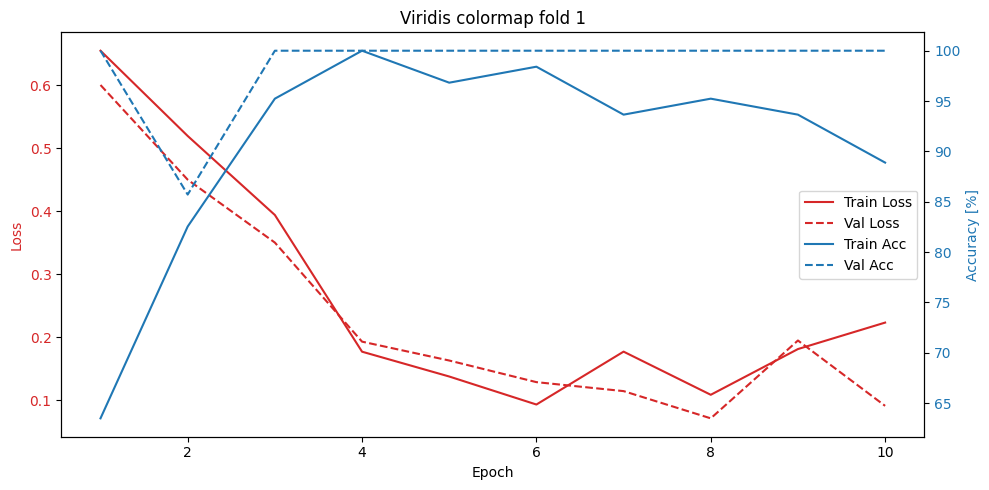


========== FOLD 2/10 ==========
Epoch [1/10] TRAIN Loss: 0.5989 Acc: 71.43% | VAL Loss: 0.4868 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4367 Acc: 92.06% | VAL Loss: 0.3297 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2551 Acc: 100.00% | VAL Loss: 0.3197 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2040 Acc: 95.24% | VAL Loss: 0.1939 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2609 Acc: 88.89% | VAL Loss: 0.1034 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1202 Acc: 98.41% | VAL Loss: 0.2599 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1630 Acc: 95.24% | VAL Loss: 0.2580 Acc: 85.71% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1499 Acc: 93.65% | VAL Loss: 0.1058 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.2029 Acc: 92.06% | VAL Loss: 0.3761 Acc: 85.71% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.2378 Acc: 85.71% | VAL Loss: 0.0977 Acc: 100.00% | LR: 5.00e-05


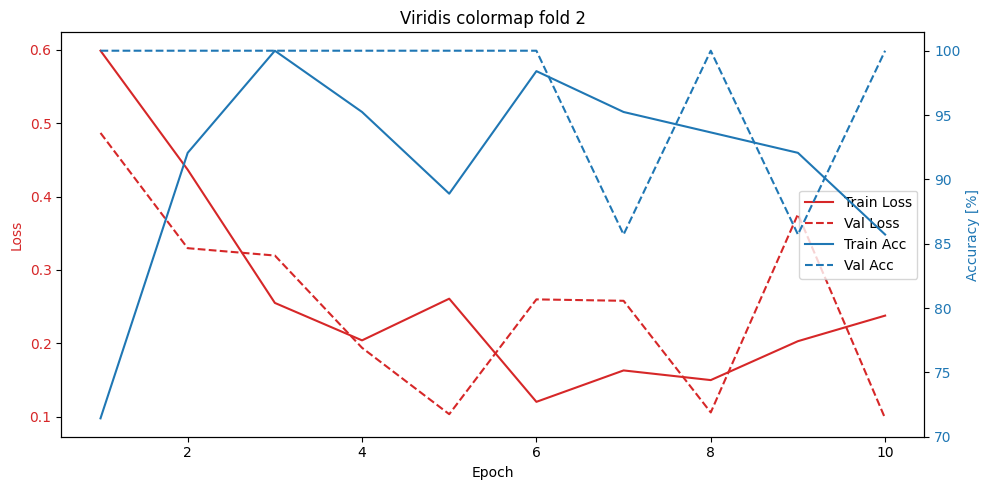


========== FOLD 3/10 ==========
Epoch [1/10] TRAIN Loss: 0.6719 Acc: 57.14% | VAL Loss: 0.6185 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5230 Acc: 84.13% | VAL Loss: 0.4942 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3448 Acc: 93.65% | VAL Loss: 0.3190 Acc: 85.71% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3650 Acc: 84.13% | VAL Loss: 0.2132 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2150 Acc: 95.24% | VAL Loss: 0.1389 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2976 Acc: 84.13% | VAL Loss: 0.2850 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1627 Acc: 93.65% | VAL Loss: 0.1718 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.2861 Acc: 87.30% | VAL Loss: 0.2539 Acc: 100.00% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1181 Acc: 98.41% | VAL Loss: 0.0801 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1089 Acc: 98.41% | VAL Loss: 0.1156 Acc: 100.00% | LR: 5.00e-05


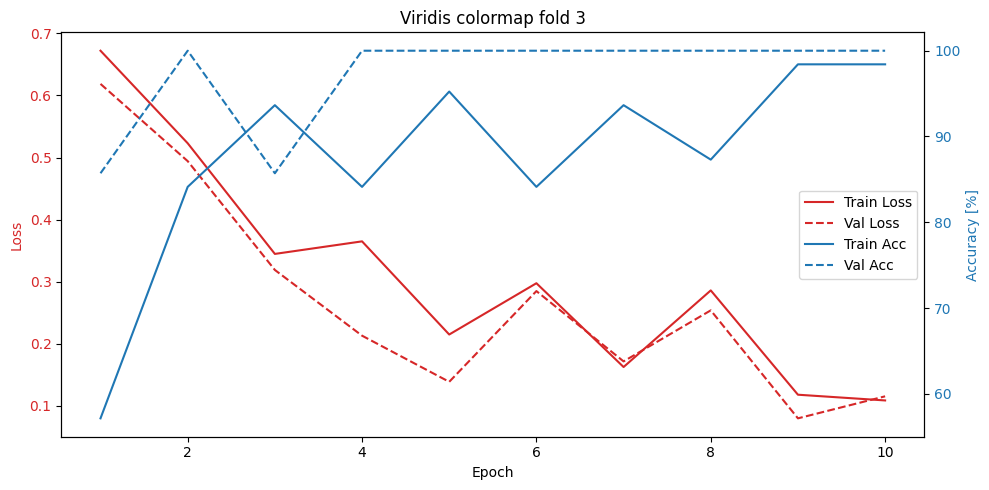


========== FOLD 4/10 ==========
Epoch [1/10] TRAIN Loss: 0.6115 Acc: 74.60% | VAL Loss: 0.5375 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4291 Acc: 90.48% | VAL Loss: 0.3074 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2621 Acc: 92.06% | VAL Loss: 0.2354 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1245 Acc: 100.00% | VAL Loss: 0.1838 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0513 Acc: 100.00% | VAL Loss: 0.1091 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.0957 Acc: 96.83% | VAL Loss: 0.1591 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.0234 Acc: 100.00% | VAL Loss: 0.0551 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0162 Acc: 100.00% | VAL Loss: 0.0470 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.3237 Acc: 88.89% | VAL Loss: 0.0780 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0861 Acc: 98.41% | VAL Loss: 0.0958 Acc: 100.00% | LR: 1.00e-04


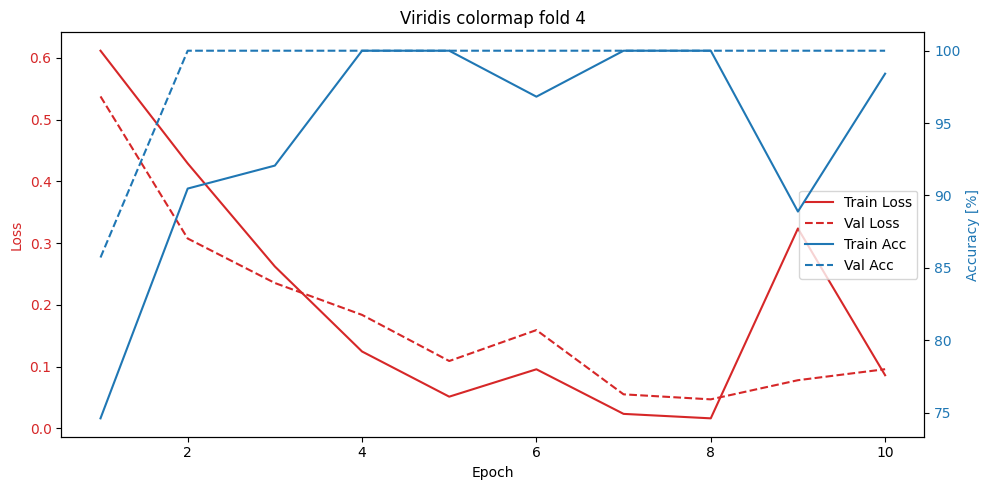


========== FOLD 5/10 ==========
Epoch [1/10] TRAIN Loss: 0.6576 Acc: 58.73% | VAL Loss: 0.5836 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5226 Acc: 79.37% | VAL Loss: 0.4622 Acc: 85.71% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3887 Acc: 88.89% | VAL Loss: 0.3462 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2947 Acc: 88.89% | VAL Loss: 0.2859 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1449 Acc: 98.41% | VAL Loss: 0.1774 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1142 Acc: 96.83% | VAL Loss: 0.2450 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1973 Acc: 88.89% | VAL Loss: 0.1521 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0856 Acc: 98.41% | VAL Loss: 0.0915 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.3219 Acc: 88.89% | VAL Loss: 0.1361 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1585 Acc: 95.24% | VAL Loss: 0.2577 Acc: 85.71% | LR: 1.00e-04


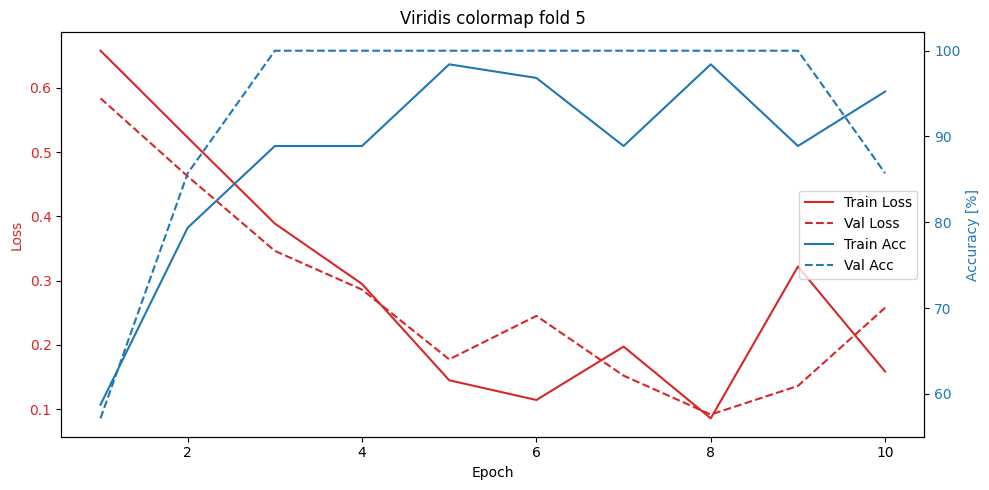


========== FOLD 6/10 ==========
Epoch [1/10] TRAIN Loss: 0.6586 Acc: 58.73% | VAL Loss: 0.5580 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4866 Acc: 85.71% | VAL Loss: 0.4475 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4220 Acc: 88.89% | VAL Loss: 0.3252 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2868 Acc: 92.06% | VAL Loss: 0.3348 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2401 Acc: 98.41% | VAL Loss: 0.1967 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.1773 Acc: 95.24% | VAL Loss: 0.1294 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2032 Acc: 88.89% | VAL Loss: 0.1127 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0887 Acc: 98.41% | VAL Loss: 0.1524 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.1549 Acc: 95.24% | VAL Loss: 0.1505 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.3261 Acc: 80.95% | VAL Loss: 0.0796 Acc: 100.00% | LR: 1.00e-04


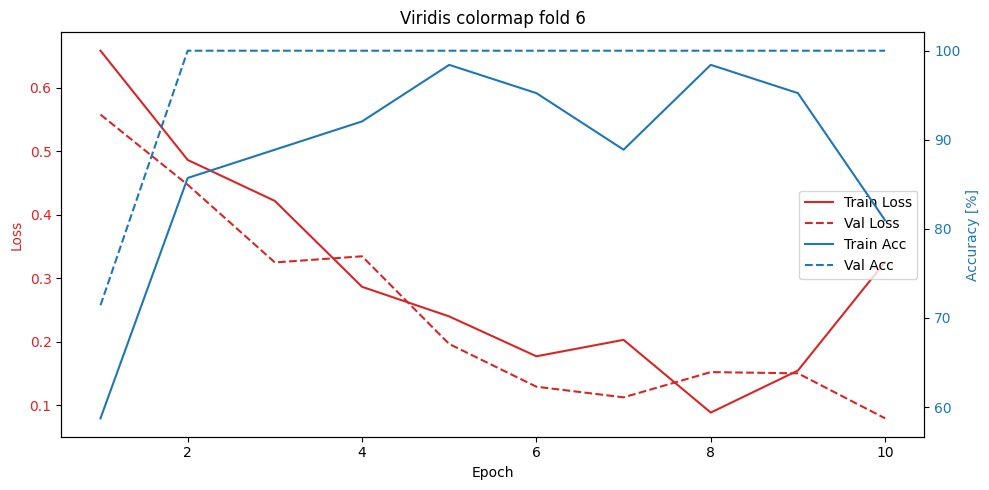


========== FOLD 7/10 ==========
Epoch [1/10] TRAIN Loss: 0.6281 Acc: 71.43% | VAL Loss: 0.5684 Acc: 71.43% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4704 Acc: 85.71% | VAL Loss: 0.4829 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.2986 Acc: 93.65% | VAL Loss: 0.2827 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.1659 Acc: 96.83% | VAL Loss: 0.1209 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2573 Acc: 85.71% | VAL Loss: 0.2389 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.4421 Acc: 82.54% | VAL Loss: 0.3968 Acc: 85.71% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2252 Acc: 90.48% | VAL Loss: 0.2151 Acc: 100.00% | LR: 5.00e-05
Epoch [8/10] TRAIN Loss: 0.1960 Acc: 93.65% | VAL Loss: 0.3883 Acc: 71.43% | LR: 5.00e-05
Epoch [9/10] TRAIN Loss: 0.1881 Acc: 96.83% | VAL Loss: 0.0945 Acc: 100.00% | LR: 5.00e-05
Epoch [10/10] TRAIN Loss: 0.1534 Acc: 93.65% | VAL Loss: 0.5093 Acc: 71.43% | LR: 5.00e-05


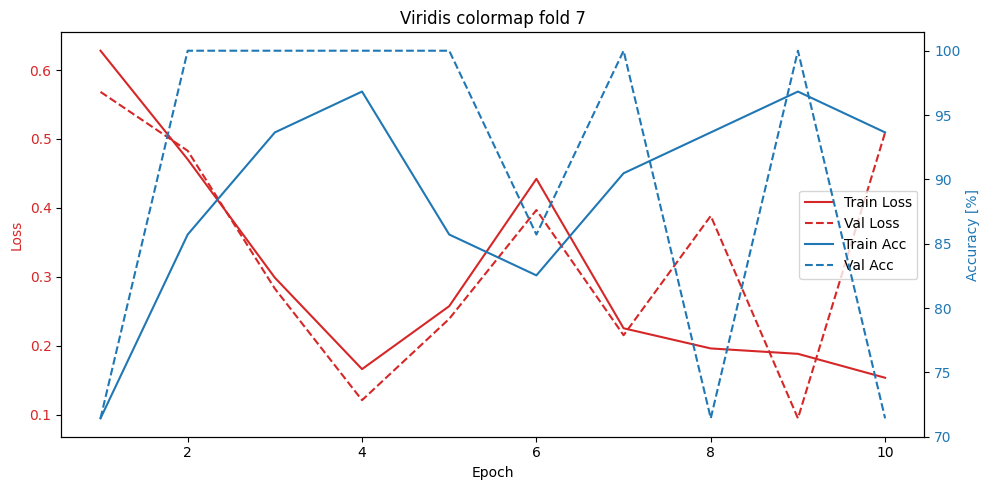


========== FOLD 8/10 ==========
Epoch [1/10] TRAIN Loss: 0.6621 Acc: 60.32% | VAL Loss: 0.5823 Acc: 57.14% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.4718 Acc: 87.30% | VAL Loss: 0.4531 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3876 Acc: 82.54% | VAL Loss: 0.3341 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2013 Acc: 96.83% | VAL Loss: 0.1845 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.0917 Acc: 100.00% | VAL Loss: 0.1579 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.2035 Acc: 90.48% | VAL Loss: 0.1034 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1078 Acc: 95.24% | VAL Loss: 0.1408 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0361 Acc: 100.00% | VAL Loss: 0.2430 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0249 Acc: 100.00% | VAL Loss: 0.0390 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0529 Acc: 98.41% | VAL Loss: 0.1063 Acc: 100.00% | LR: 1.00e-04


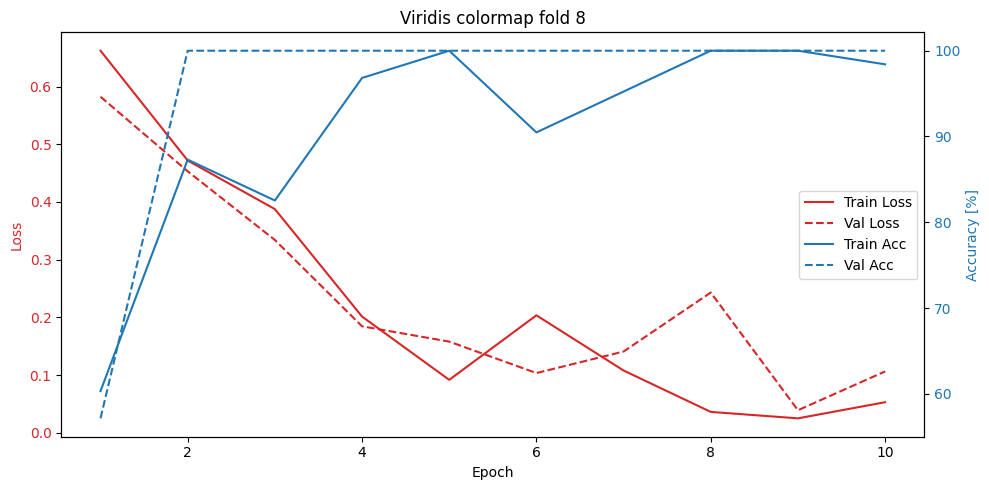


========== FOLD 9/10 ==========
Epoch [1/10] TRAIN Loss: 0.6357 Acc: 61.90% | VAL Loss: 0.5095 Acc: 85.71% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5189 Acc: 84.13% | VAL Loss: 0.4415 Acc: 100.00% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.4170 Acc: 85.71% | VAL Loss: 0.3582 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.3608 Acc: 82.54% | VAL Loss: 0.2492 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.2028 Acc: 96.83% | VAL Loss: 0.2646 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.0808 Acc: 100.00% | VAL Loss: 0.0895 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.1425 Acc: 93.65% | VAL Loss: 0.1281 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.1392 Acc: 93.65% | VAL Loss: 0.0575 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0746 Acc: 98.41% | VAL Loss: 0.0608 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.0550 Acc: 100.00% | VAL Loss: 0.2539 Acc: 85.71% | LR: 1.00e-04


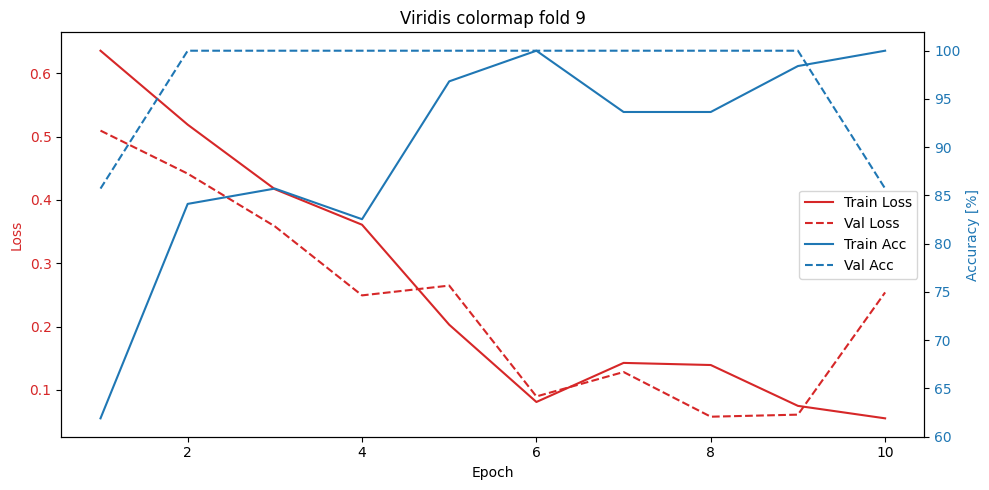


========== FOLD 10/10 ==========
Epoch [1/10] TRAIN Loss: 0.6777 Acc: 55.56% | VAL Loss: 0.5829 Acc: 100.00% | LR: 1.00e-04
Epoch [2/10] TRAIN Loss: 0.5196 Acc: 92.06% | VAL Loss: 0.4657 Acc: 71.43% | LR: 1.00e-04
Epoch [3/10] TRAIN Loss: 0.3618 Acc: 93.65% | VAL Loss: 0.2249 Acc: 100.00% | LR: 1.00e-04
Epoch [4/10] TRAIN Loss: 0.2028 Acc: 96.83% | VAL Loss: 0.1376 Acc: 100.00% | LR: 1.00e-04
Epoch [5/10] TRAIN Loss: 0.1373 Acc: 96.83% | VAL Loss: 0.1164 Acc: 100.00% | LR: 1.00e-04
Epoch [6/10] TRAIN Loss: 0.3027 Acc: 88.89% | VAL Loss: 0.1963 Acc: 100.00% | LR: 1.00e-04
Epoch [7/10] TRAIN Loss: 0.2252 Acc: 92.06% | VAL Loss: 0.1990 Acc: 100.00% | LR: 1.00e-04
Epoch [8/10] TRAIN Loss: 0.0590 Acc: 100.00% | VAL Loss: 0.1144 Acc: 100.00% | LR: 1.00e-04
Epoch [9/10] TRAIN Loss: 0.0900 Acc: 96.83% | VAL Loss: 0.1302 Acc: 100.00% | LR: 1.00e-04
Epoch [10/10] TRAIN Loss: 0.1543 Acc: 95.24% | VAL Loss: 0.1142 Acc: 100.00% | LR: 1.00e-04


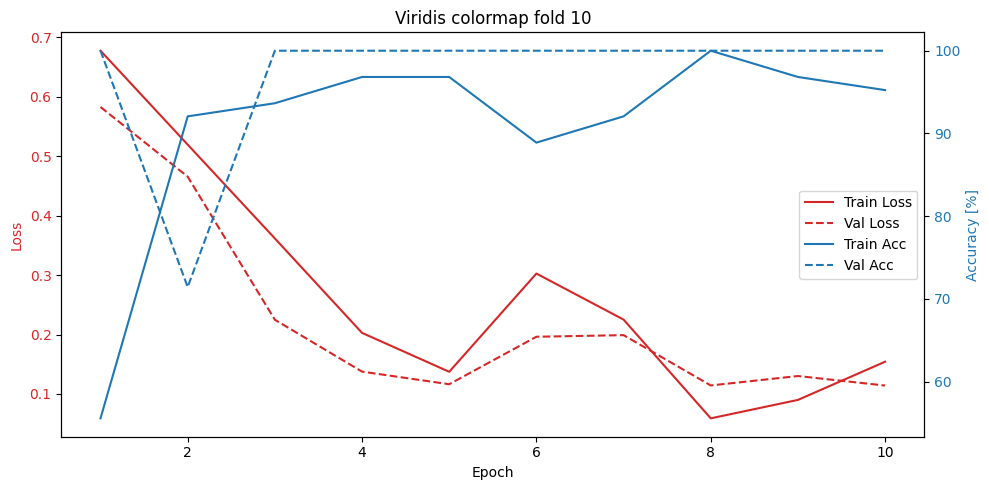

In [9]:
for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print(f'\n========== FOLD {fold+1}/{num_folds} ==========')

    model = CNN_LSTM().to(device)
    optimizer = torch.optim.NAdam(model.parameters(), lr=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    best_val_loss = 1e10
    best_model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'

    # ===== HISTORIA =====
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # ===================== TRAIN =====================
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for videos, y in train_loader:
            videos = videos.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * videos.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss /= len(train_dataset)
        train_acc = 100 * correct / total

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===================== VAL =====================
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for videos, y in val_loader:
                videos = videos.to(device)
                y = y.to(device)

                outputs = model(videos)
                loss = criterion(outputs, y)

                val_loss += loss.item() * videos.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss /= len(val_dataset)
        val_acc = 100 * correct / total

        scheduler.step(val_loss)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        current_lr = optimizer.param_groups[0]['lr']

        print(
            f'Epoch [{epoch+1}/{num_epochs}] '
            f'TRAIN Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
            f'VAL Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | '
            f'LR: {current_lr:.2e}'
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # ===================== PLOT =====================
    epochs = range(1, num_epochs + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, train_losses, label='Train Loss', color='tab:red')
    ax1.plot(epochs, val_losses, label='Val Loss', color='tab:red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy [%]', color='tab:blue')
    ax2.plot(epochs, train_accs, label='Train Acc', color='tab:blue')
    ax2.plot(epochs, val_accs, label='Val Acc', color='tab:blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    plt.title(f'Viridis colormap fold {fold+1}')
    plt.tight_layout()
    plt.show()


In [10]:
print('\n========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========')

final_results = []

full_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    generator=g
)

for fold in range(num_folds):
    model_path = checkpoint_dir / f'best_model_fold_{fold}.pt'
    print(f'\nFold {fold+1}:')

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        error_fragments = []
        for batch_idx, (videos, y) in enumerate(full_loader):
            videos = videos.to(device)
            y = y.to(device)

            outputs = model(videos)
            _, preds = torch.max(outputs, 1)

            incorrect_idx = (preds != y).nonzero(as_tuple=True)[0]

            start_idx = batch_idx * full_loader.batch_size
            global_incorrect_idx = start_idx + incorrect_idx

            for idx in global_incorrect_idx:
                full_path = full_loader.dataset.samples[idx.item()][0]
                full_path_str = str(full_path)
                parts = full_path_str.split('/')[-3:-1]
                fragment = '/'.join(parts)
                error_fragments.append(fragment)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    if error_fragments:
        print("Errors:")
        for f in error_fragments:
            print(f)

    metrics = {
        'fold': fold,
        'acc': accuracy_score(all_labels, all_preds),
        'prec': precision_score(all_labels, all_preds, average='binary'),
        'rec': recall_score(all_labels, all_preds, average='binary'),
        'f1': f1_score(all_labels, all_preds, average='binary'),
    }

    final_results.append(metrics)
    print(metrics)



========== FINAL EVAL: EACH FOLD MODEL ON FULL DATASET ==========

Fold 1:
{'fold': 0, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 2:
{'fold': 1, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 3:
{'fold': 2, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 4:
Errors:
fall/sequence-08
{'fold': 3, 'acc': 0.9857142857142858, 'prec': 1.0, 'rec': 0.9666666666666667, 'f1': 0.9830508474576272}

Fold 5:
{'fold': 4, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 6:
{'fold': 5, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 7:
{'fold': 6, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 8:
{'fold': 7, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 9:
{'fold': 8, 'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0}

Fold 10:
Errors:
fall/sequence-14
{'fold': 9, 'acc': 0.9857142857142858, 'prec': 1.0, 'rec': 0.9666666666666667, 'f1': 0.9830508474576272}


In [11]:
print('\n========== CV RESULTS ==========')

for metric in final_results[0].keys():
    if metric == 'fold':
        continue
    values = [f[metric] for f in final_results]
    print(
        f'{metric.upper()}: '
        f'{np.mean(values)*100:.2f}% std: {np.std(values)*100:.2f}%'
    )



========== CV RESULTS ==========
ACC: 99.71% std: 0.57%
PREC: 100.00% std: 0.00%
REC: 99.33% std: 1.33%
F1: 99.66% std: 0.68%


In [12]:
full_loader.dataset.samples

[([PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-001.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-002.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-003.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-004.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-005.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-006.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-007.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-008.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-009.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-010.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-011.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-012.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-013.npy'),
   PosixPath('../data_viridis/adl/sequence-07/adl-07-cam0-d-014.npy'),
   Pos